In [18]:
import jax.numpy as jnp
import jax
from functools import partial
from jax import random
import flax
import flax.linen as nn
from flax.training.train_state import TrainState
import optax
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline

In [19]:
rng = random.PRNGKey(0)

class Net(nn.Module):
    n_hidden: int
    n_output: int

    @nn.compact
    def __call__(self, x):
        x = nn.relu( nn.Dense(self.n_hidden)(x) )
        x = nn.relu( nn.Dense(self.n_hidden)(x) )
        x = nn.Dense(self.n_output)(x)
        return x
    
def loss_fn(params, inputs, targets, apply_fn):
    predictions = apply_fn(params, inputs)
    return jnp.mean((predictions - targets)**2)

def inner_update(params, x1, y1, apply_fn, alpha=0.1):
    grads = jax.grad(loss_fn)(params, x1, y1, apply_fn)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return jax.tree.map(inner_sgd_fn, grads, params)

def maml_loss(params, x1, y1, x2, y2, apply_fn):
    params2 = inner_update(params, x1, y1, apply_fn)
    return loss_fn(params2, x2, y2, apply_fn)
    
@jax.jit
def meta_update(model_state: TrainState, x1, y1, x2, y2):
    loss, grads = jax.value_and_grad(maml_loss)(model_state.params, x1, x2, y1, y2, model_state.apply_fn)
    model_state = model_state.apply_gradients(grads=grads)
    return model_state, loss
    
def create_state(rng, model, in_shape, learning_rate):
    params = model.init(rng, jnp.zeros(in_shape))
    tx = optax.adam(learning_rate)
    return TrainState.create(apply_fn=jax.jit(model.apply), params=params, tx=tx)


In [20]:
rng, key = random.split(rng)
in_shape = (1,1)
lr = 0.0003
model = Net(n_hidden=64, n_output=1)
model_state = create_state(key, model, in_shape, lr)

In [21]:
g = lambda x, y : jnp.square(x) + y
x0 = 2.
y0 = 1.
print(f'grad(g)(x0) = {jax.grad(g)(x0, y0)}')
print(f'x0 - grad(g)(x0) = {x0 - jax.grad(g)(x0, y0)}')

def maml_objective(x, y):
    return g(x - jax.grad(g)(x, y), y)

print(f'maml_objective(x,y)={maml_objective(x0, y0)}')
print(f'x0 - maml_objective(x,y) = {x0 - jax.grad(maml_objective)(x0,y0)}')

grad(g)(x0) = 4.0
x0 - grad(g)(x0) = -2.0
maml_objective(x,y)=5.0
x0 - maml_objective(x,y) = -2.0


In [22]:
K=20
maml_losses = []

# Adam optimization
for i in tqdm(range(20_000)):
    # define the task
    rng, key1, key2, key3, key4 = random.split(rng, 5)
    A = random.uniform(key1, minval=0.1, maxval=0.5)
    phase = random.uniform(key2, minval=0., maxval=jnp.pi)
    # Meta training inner split (K examples)
    x1 = random.uniform(key3, minval=-5.0, maxval=5.0, shape=(K, 1))
    y1 = A * jnp.sin(x1 + phase)
    # meta-training outer split (1 example). Like cross-validating wrt one example
    x2 = random.uniform(key4, minval=-5.0, maxval=5.0)
    y2 = A * jnp.sin(x2 + phase)
    x2 = jnp.expand_dims(x2, axis=0)
    model_state, loss = meta_update(model_state, x1, y1, x2, y2)
    maml_losses.append(loss)
    if i % 1000 == 0:
        print(i)


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

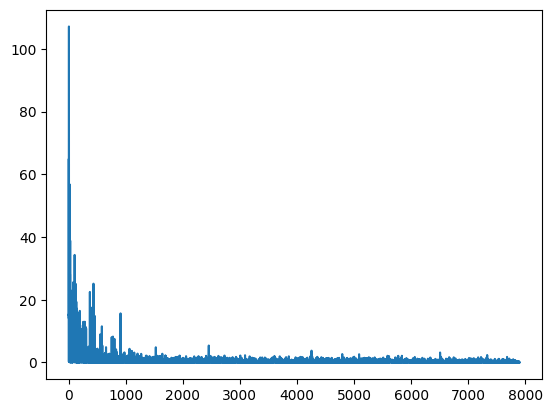

In [ ]:
plt.plot(maml_losses[100:8_000])

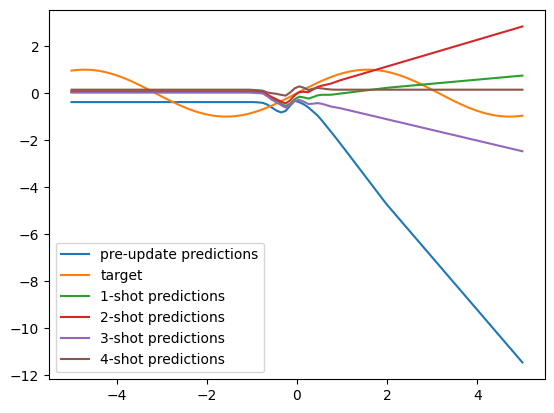

In [ ]:
xrange_inputs = jnp.linspace(-5,5,100).reshape((100,1))
targets = jnp.sin(xrange_inputs)
predictions = model_state.apply_fn(model_state.params, xrange_inputs)
#predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

rng, key = random.split(rng)
x1 = random.uniform(key, minval=-5.0, maxval=5.0, shape=(K,1))
y1 = 1.0 * jnp.sin(x1 + 0.)

net_params = model_state.params
for i in range(1,5):
    net_params = inner_update(net_params, x1, y1, model_state.apply_fn)
    predictions = model_state.apply_fn(net_params, xrange_inputs)
    plt.plot(xrange_inputs, predictions, label=f'{i}-shot predictions')

plt.legend()

In [ ]:
def sample_tasks(outter_batch_size, inner_batch_size, rng):
    As = []
    phases = []
    for _ in range(outter_batch_size):
        rng, key1, key2 = random.split(rng, 3)
        As.append(random.uniform(key1, minval=0.1, maxval=0.5))
        phases.append(random.uniform(key2, minval=0., maxval=jnp.pi))

        def get_batch(rng):
            xs, ys = [], []
            for A, phase in zip(As, phases):
                rng, key = random.split(rng, 2)
                x = random.uniform(key, minval=-5.0, maxval=5.0, shape=(inner_batch_size, 1))
                y = A * jnp.sin(x + phase)
                xs.append(x)
                ys.append(y)
            return jnp.stack(xs), jnp.stack(ys)
    
    key1, key2 = random.split(rng)
    x1, y1 = get_batch(key1)
    x2, y2 = get_batch(key2)
    return x1, y1, x2, y2

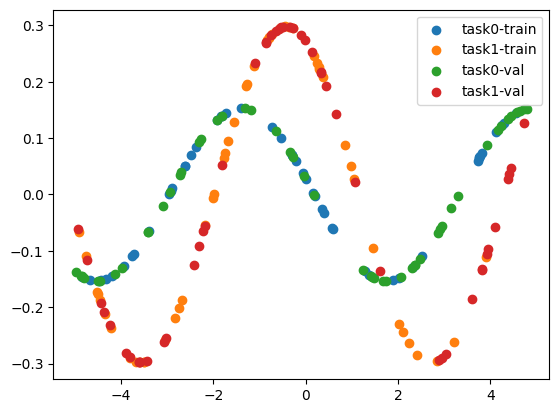

In [ ]:
outer_batch_size = 2
rng, key = random.split(rng)
x1, y1, x2, y2 = sample_tasks(outer_batch_size, 50, key)
for i in range(outer_batch_size):
    plt.scatter(x1[i], y1[i], label='task{}-train'.format(i))
for i in range(outer_batch_size):
    plt.scatter(x2[i], y2[i], label='task{}-val'.format(i))
plt.legend()

In [ ]:
rng, key1, key2 = random.split(rng, num=3)
in_shape = (1,1)
lr = 0.0003
model_state = create_state(key1, model, in_shape, lr)

def batched_maml_loss(params, x1_b, y1_b, x2_b, y2_b, apply_fn):
    task_losses = jax.vmap(partial(maml_loss, params))(x1_b, y1_b, x2_b, y2_b, apply_fn)
    return jnp.mean(task_losses)

# @jax.jit
def batched_meta_update(model_state: TrainState, x1, y1, x2, y2):
    loss, grads = jax.value_and_grad(batched_maml_loss)(model_state.params, x1, x2, y1, y2, model_state.apply_fn)
    model_state = model_state.apply_gradients(grads=grads)
    return model_state, loss
    
batched_maml_losses = []
K = 20
for i in tqdm(range(20_000)):
    x1_b, y1_b, x2_b, y2_b = sample_tasks(4, K, key2)
    # print(f"x1_b: {x1_b}, y1_b: {y1_b}, x2_b: {x2_b}, y2_b: {y2_b}")
    model_state, loss = meta_update(model_state, x1_b, y1_b, x2_b, y2_b)
    batched_maml_losses.append(loss)

    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


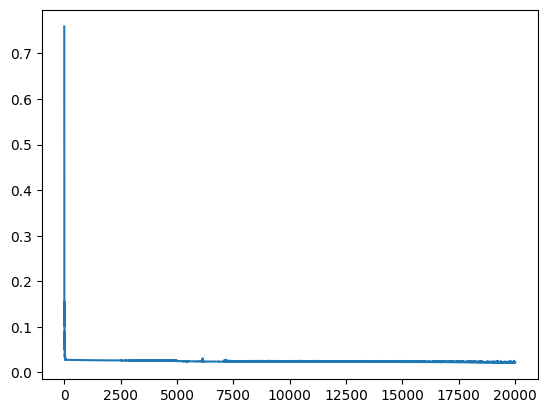

In [ ]:
plt.plot(batched_maml_losses)

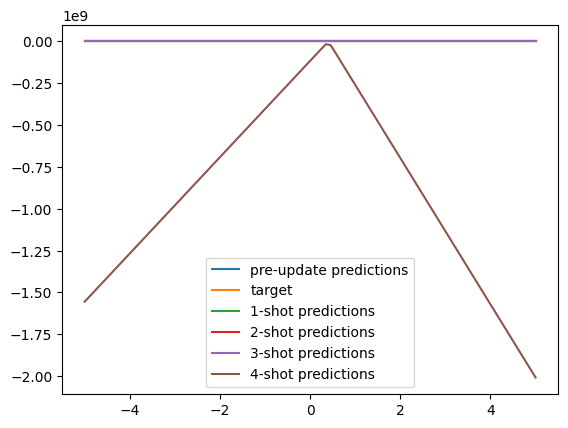

In [ ]:
xrange_inputs = jnp.linspace(-5,5,100).reshape((100,1))
targets = jnp.sin(xrange_inputs)
predictions = model_state.apply_fn(model_state.params, xrange_inputs)
#predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

rng, key = random.split(rng)
x1 = random.uniform(key, minval=-5.0, maxval=5.0, shape=(K,1))
y1 = 1.0 * jnp.sin(x1 + 0.)

net_params = model_state.params
for i in range(1,5):
    net_params = inner_update(net_params, x1, y1, model_state.apply_fn)
    predictions = model_state.apply_fn(net_params, xrange_inputs)
    plt.plot(xrange_inputs, predictions, label=f'{i}-shot predictions')

plt.legend()